### Problem:
- What would be the best camera to use for a Traffic E-Challan System?

### Dataset:
- `cameras.csv` from [Kaggle](https://www.kaggle.com/datasets/crawford/1000-cameras-dataset "Kaggle 1000-cameras").

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report

In [ ]:
cameras = pd.read_csv('x:REDACTED\08 - E-Challan Cameras Project\cameras.csv')

# from google.colab import files
# uploaded = files.upload()
# cameras = pd.read_csv('cameras.csv')

cameras.head()

Saving cameras.csv to cameras.csv


,Model,Release date,Max resolution,Low resolution,Effective pixels,Zoom wide (W),Zoom tele (T),Normal focus range,Macro focus range,Storage included,Weight (inc. batteries),Dimensions,Price
0,Agfa ePhoto 1280,1997,1024.0,640.0,0.0,38.0,114.0,70.0,40.0,4.0,420.0,95.0,179.0
1,Agfa ePhoto 1680,1998,1280.0,640.0,1.0,38.0,114.0,50.0,0.0,4.0,420.0,158.0,179.0
2,Agfa ePhoto CL18,2000,640.0,0.0,0.0,45.0,45.0,0.0,0.0,2.0,0.0,0.0,179.0
3,Agfa ePhoto CL30,1999,1152.0,640.0,0.0,35.0,35.0,0.0,0.0,4.0,0.0,0.0,269.0
4,Agfa ePhoto CL30 Clik!,1999,1152.0,640.0,0.0,43.0,43.0,50.0,0.0,40.0,300.0,128.0,1299.0


In [5]:
cameras.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Model                    1038 non-null   object 
 1   Release date             1038 non-null   int64  
 2   Max resolution           1038 non-null   float64
 3   Low resolution           1038 non-null   float64
 4   Effective pixels         1038 non-null   float64
 5   Zoom wide (W)            1038 non-null   float64
 6   Zoom tele (T)            1038 non-null   float64
 7   Normal focus range       1038 non-null   float64
 8   Macro focus range        1037 non-null   float64
 9   Storage included         1036 non-null   float64
 10  Weight (inc. batteries)  1036 non-null   float64
 11  Dimensions               1036 non-null   float64
 12  Price                    1038 non-null   float64
dtypes: float64(11), int64(1), object(1)
memory usage: 105.6+ KB


In [6]:
cameras.isnull().sum()

,0
Model,0
Release date,0
Max resolution,0
Low resolution,0
Effective pixels,0
Zoom wide (W),0
Zoom tele (T),0
Normal focus range,0
Macro focus range,1
Storage included,2


For a traffic E-Challan System, top priorities are:

- Reliably readable License Plates (high effective pixels, high max resolution, accurate autofocus)

- Long Range / Zoom

- Low-Light / Night Capability

- Robustness & Mountability

- Cost-effectiveness

### Data Cleaning
1. Column Renaming
    - We’ll rename columns with units (e.g. "Effective pixels (MP)").

2. Dropping
    - Remove `Macro focus range` and `Storage included`.

3. Missing Values
    - We’ll check for nulls; if just a few values, we can drop them outright.

4. Outlier & Sanity Check
    - We’ll check for:
        - Price values too high (`>5000 USD`) or `0` → potential outliers.
        - Effective pixels `< 0.5` or `> 100` → unrealistic, mark or cap.
        - Any negative or zero values in zoom or focus → correct/drop.

5. Derived Fields
    - We’ll engineer helpful columns:
        - Camera_Age = 2025 - Release date
        - Zoom_Ratio = Zoom tele / Zoom wide
        - Price_per_MP = Price / Effective pixels

In [7]:
cameras.shape

(1038, 13)

In [8]:
# 1. Column Renaming
rename_map = {
    "Model": "Model",
    "Release date": "Release date (Year)",
    "Max resolution": "Max resolution (MP)",
    "Low resolution": "Low resolution (MP)",
    "Effective pixels": "Effective pixels (MP)",
    "Zoom wide (W)": "Zoom wide (mm)",
    "Zoom tele (T)": "Zoom tele (mm)",
    "Normal focus range": "Normal focus range (cm)",
    "Macro focus range": "Macro focus range (cm)",
    "Storage included": "Storage included (MB)",
    "Weight (inc. batteries)": "Weight (g)",
    "Dimensions": "Dimensions (cm³)",
    "Price": "Price (USD)"
}

cameras = cameras.rename(columns=rename_map)

# quick inspection
display(cameras.head(6))

,Model,Release date (Year),Max resolution (MP),Low resolution (MP),Effective pixels (MP),Zoom wide (mm),Zoom tele (mm),Normal focus range (cm),Macro focus range (cm),Storage included (MB),Weight (g),Dimensions (cm³),Price (USD)
0,Agfa ePhoto 1280,1997,1024.0,640.0,0.0,38.0,114.0,70.0,40.0,4.0,420.0,95.0,179.0
1,Agfa ePhoto 1680,1998,1280.0,640.0,1.0,38.0,114.0,50.0,0.0,4.0,420.0,158.0,179.0
2,Agfa ePhoto CL18,2000,640.0,0.0,0.0,45.0,45.0,0.0,0.0,2.0,0.0,0.0,179.0
3,Agfa ePhoto CL30,1999,1152.0,640.0,0.0,35.0,35.0,0.0,0.0,4.0,0.0,0.0,269.0
4,Agfa ePhoto CL30 Clik!,1999,1152.0,640.0,0.0,43.0,43.0,50.0,0.0,40.0,300.0,128.0,1299.0
5,Agfa ePhoto CL45,2001,1600.0,640.0,1.0,51.0,51.0,50.0,20.0,8.0,270.0,119.0,179.0


In [9]:
# 2. Dropping
cameras = cameras.drop(columns=["Macro focus range (cm)", "Storage included (MB)"])

cameras.head(2)

,Model,Release date (Year),Max resolution (MP),Low resolution (MP),Effective pixels (MP),Zoom wide (mm),Zoom tele (mm),Normal focus range (cm),Weight (g),Dimensions (cm³),Price (USD)
0,Agfa ePhoto 1280,1997,1024.0,640.0,0.0,38.0,114.0,70.0,420.0,95.0,179.0
1,Agfa ePhoto 1680,1998,1280.0,640.0,1.0,38.0,114.0,50.0,420.0,158.0,179.0


In [10]:
# 3. Missing Values
cameras.isnull().sum().sort_values(ascending=False)

,0
Dimensions (cm³),2
Weight (g),2
Model,0
Max resolution (MP),0
Release date (Year),0
Low resolution (MP),0
Effective pixels (MP),0
Zoom tele (mm),0
Zoom wide (mm),0
Normal focus range (cm),0


In [11]:
# For Dimensions, fill NaNs with median
if cameras["Dimensions (cm³)"].isna().any():
    cameras["Dimensions (cm³)"] = cameras["Dimensions (cm³)"].fillna(cameras["Dimensions (cm³)"].median())

# For Weight, fill NaNs with median
if cameras["Weight (g)"].isna().any():
    cameras["Weight (g)"] = cameras["Weight (g)"].fillna(cameras["Weight (g)"].median())

cameras.isnull().sum().sort_values(ascending=False)

,0
Model,0
Release date (Year),0
Max resolution (MP),0
Low resolution (MP),0
Effective pixels (MP),0
Zoom wide (mm),0
Zoom tele (mm),0
Normal focus range (cm),0
Weight (g),0
Dimensions (cm³),0


In [12]:
# Convert types to numeric where appropriate
num_cols = [
    "Max resolution (MP)", "Low resolution (MP)", "Effective pixels (MP)",
    "Zoom wide (mm)", "Zoom tele (mm)", "Normal focus range (cm)",
    "Weight (g)", "Dimensions (cm³)", "Price (USD)", "Release date (Year)"
]

for c in num_cols:
    if c in cameras.columns:
        cameras[c] = pd.to_numeric(cameras[c], errors="coerce")

In [13]:
# 4. Basic invalid-value filtering
# Remove rows with non-positive essential values
essential = ["Effective pixels (MP)", "Zoom tele (mm)", "Zoom wide (mm)", "Price (USD)"]
cameras = cameras.dropna(subset=essential).copy()

cameras = cameras[(cameras["Effective pixels (MP)"] > 0) & (cameras["Price (USD)"] > 0)]

# Cap unrealistic megapixels (if any) — common cameras < 100 MP in this dataset
cameras = cameras[cameras["Effective pixels (MP)"] < 200]

In [14]:
cameras.shape
# 2 columns and 35 rows dropped

(1003, 11)

In [15]:
# 5. Custom Columns

# If release year exists, create 'Camera Age' otherwise leave NaN
current_year = 2025
if "Release date (Year)" in cameras.columns:
    cameras["Camera Age (Years)"] = current_year - cameras["Release date (Year)"]

In [16]:
# Create Zoom Ratio (tele / wide).
cameras["Zoom Ratio"] = np.where(
    (cameras["Zoom wide (mm)"] > 0),
    cameras["Zoom tele (mm)"] / cameras["Zoom wide (mm)"],
    np.nan
)

# Fill remaining Zoom Ratio NaNs with median
if "Zoom Ratio" in cameras.columns:
    median_zoom_ratio = cameras["Zoom Ratio"].median()
    cameras["Zoom Ratio"] = cameras["Zoom Ratio"].fillna(median_zoom_ratio)

In [17]:
# Price per MP — useful feature
cameras["Price per MP (USD/MP)"] = cameras["Price (USD)"] / cameras["Effective pixels (MP)"]

### Rule-Based Weighted Score and Analysis

- We’ll normalize relevant features (0–1) and combine them.

- All normalized via `MinMax scaling` so final score in range `0–100`.

- We can interpret `score > 80` as “ideal candidates" for E-Challan system.

This method assigns each camera a **Suitability Score (0–100)** using key performance features weighted by their relevance to traffic surveillance.

| Feature | Weight | Direction | Reasoning |
|----------|---------|------------|------------|
| `Effective pixels (MP)` | 0.25 | Higher is better | Clearer license plate and face recognition |
| `Max resolution (MP)` | 0.15 | Higher is better | Supports zoomed-in evidence captures |
| `Low resolution (MP)` | 0.10 | Higher is better | Ensures good quality under lower settings |
| `Zoom tele (mm)` | 0.15 | Higher is better | Allows distant plate recognition |
| `Zoom ratio` | 0.10 | Higher is better | Flexibility in dynamic road conditions |
| `Normal focus range (cm)` | 0.05 | Lower is better | Better near-focus precision |
| `Weight (g)` | 0.05 | Lower is better | Easier mounting on poles or vehicles |
| `Dimensions (cm³)` | 0.05 | Lower is better | Compact cameras are easier to install |
| `Price (USD)` | 0.05 | Lower is better | More cost-efficient for large deployments |
| `Camera Age (Years)` | 0.05 | Lower is better | Newer models have better tech and reliability |

Weights were normalized to sum to 1.  
Each feature was **scaled 0–1 using MinMaxScaler**, inverted where lower values are better, and combined via a **weighted average**.  
The resulting **Suitability Score (0–100)** expresses how well each camera meets the surveillance and cost requirements of the E-Challan system.


In [18]:
# Define features and weights (weights should sum to 1; we'll normalize automatically)
# True = Very Important Feature
# False = Less Important Feature

features_weights = {
    "Effective pixels (MP)": (0.25, True),
    "Max resolution (MP)": (0.15, True),
    "Low resolution (MP)": (0.10, True),
    "Zoom tele (mm)": (0.15, True),
    "Zoom Ratio": (0.10, True),
    "Normal focus range (cm)": (0.05, False),  # lower better
    "Weight (g)": (0.05, False),                # lower better
    "Dimensions (cm³)": (0.05, False),         # lower better
    "Price (USD)": (0.05, False),              # lower better
    "Camera Age (Years)": (0.05, False)        # lower better
}

In [19]:
# Build DataFrame X for scaling
feat_names = [f for f in features_weights.keys() if f in cameras.columns]
X = cameras[feat_names].copy()

# Invert columns where lower is better by transforming x -> max - x
invert_cols = [f for f,(w,higher) in features_weights.items() if (f in X.columns) and not higher]
X_invert = X.copy()
for col in invert_cols:
    X_invert[col] = X_invert[col].max() - X_invert[col]

In [20]:
# Scale 0-1
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_invert), columns=feat_names, index=X.index)

# Normalize weight array to sum to 1
weights = np.array([features_weights[f][0] for f in feat_names], dtype=float)
weights = weights / weights.sum()

# compute raw score and scale to 0-100
raw_score = X_scaled.values.dot(weights)
cameras["Suitability Score (0-100)"] = 100 * (raw_score - raw_score.min()) / (raw_score.max() - raw_score.min())

In [21]:
# show top 10
top10 = cameras.sort_values("Suitability Score (0-100)", ascending=False).head(10)
display(top10[["Model", "Suitability Score (0-100)", "Price (USD)", "Effective pixels (MP)", "Zoom tele (mm)", "Zoom Ratio", "Camera Age (Years)"]])

,Model,Suitability Score (0-100),Price (USD),Effective pixels (MP),Zoom tele (mm),Zoom Ratio,Camera Age (Years)
666,Olympus SP-560 UZ,100.000000,449.0,8.0,486.0,18.0,18
708,Panasonic Lumix DMC-FZ18,99.480476,149.0,8.0,504.0,18.0,18
665,Olympus SP-550 UZ,97.086348,449.0,7.0,504.0,18.0,18
715,Panasonic Lumix DMC-FZ50,93.929231,149.0,10.0,420.0,12.0,19
278,Fujifilm FinePix S8000 fd,93.578825,399.0,8.0,486.0,18.0,18
476,Leica V-LUX 1,93.486188,509.0,10.0,420.0,12.0,19
54,Canon EOS-1Ds Mark III,92.893896,7999.0,21.0,0.0,3.0,18
927,Sony DSC-H7,92.224219,429.0,8.0,465.0,15.0,18
928,Sony DSC-H9,92.039303,429.0,8.0,465.0,15.0,18
38,Canon PowerShot A650 IS,88.492947,399.0,12.0,210.0,6.0,18


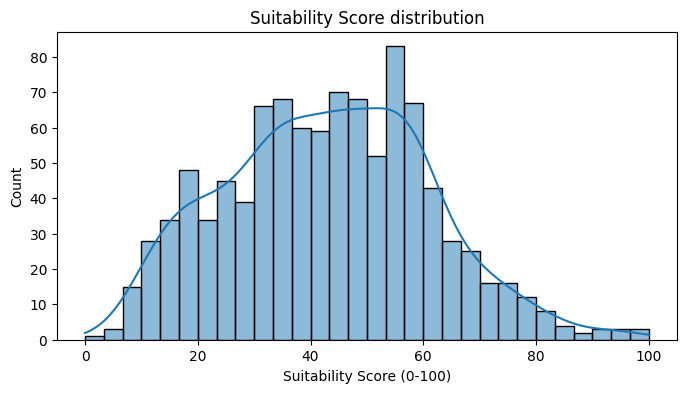

In [22]:
plt.figure(figsize=(8,4))
sns.histplot(cameras["Suitability Score (0-100)"], bins=30, kde=True)

plt.title("Suitability Score distribution")
plt.xlabel("Suitability Score (0-100)")
plt.show()

![standard normal distribution pic](<standard normal distribution.png>)

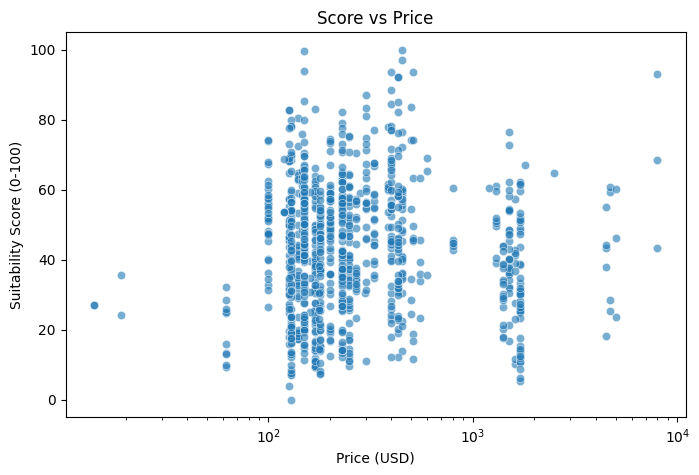

In [23]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=cameras, x="Price (USD)", y="Suitability Score (0-100)", alpha=0.6)
plt.xscale('log')  # price can be skewed, log scale often helps

plt.title("Score vs Price")
plt.show()

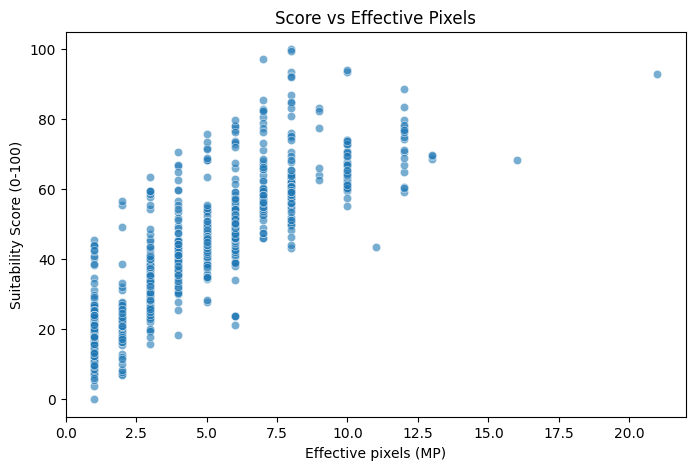

In [24]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=cameras, x="Effective pixels (MP)", y="Suitability Score (0-100)", alpha=0.6)
plt.title("Score vs Effective Pixels")
plt.show()

### ML Extension

Once we compute the rule-based `Suitability Score`, we can approach ML in two ways:

#### A. Regression

- Treat the rule-based score as the “target variable”.

- Use all other numeric features to predict it.

- Train/test split (e.g., 80/20).

- Use models like `LinearRegression` and `RandomForestRegressor`.

- Compare `RMSE` and `R²`.

**Goal:** See if the machine can learn which specs most strongly predict “suitability”.


#### B. Classification

- Convert the score to classes:

    - High (`≥80`) → Suitable

    - Medium (`60–79`) → Okay

    - Low (`<60`) → Unsuitable

- Train models: `LogisticRegression`, `RandomForestClassifier`.

- Evaluate with `accuracy` and `ROC-AUC`.

**Goal:** Automatically classify new cameras into categories.

In [25]:
# Regression modeling (predict the rule-based score)

# Prepare X, y
model_features = [f for f in feat_names if f != "Price (USD)"]  # we can drop price if you want price-free model

X_model = cameras[model_features].copy()
y = cameras["Suitability Score (0-100)"].values

In [26]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_model, y, test_size=0.2, random_state=42)

In [27]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
print(f"LinearRegression - 'RMSE:' {np.sqrt(mean_squared_error(y_test, y_pred_lr))} 'R2:' {r2_score(y_test, y_pred_lr)}")

LinearRegression - 'RMSE:' 0.8986345334992556 'R2:' 0.9977875708144992


In [28]:
# RandomForestRegressor
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print(f"RandomForestRegressor - 'RMSE:' {np.sqrt(mean_squared_error(y_test, y_pred_rf))} 'R2:' {r2_score(y_test, y_pred_rf)}")

RandomForestRegressor - 'RMSE:' 2.639781769376394 'R2:' 0.9809085365074044


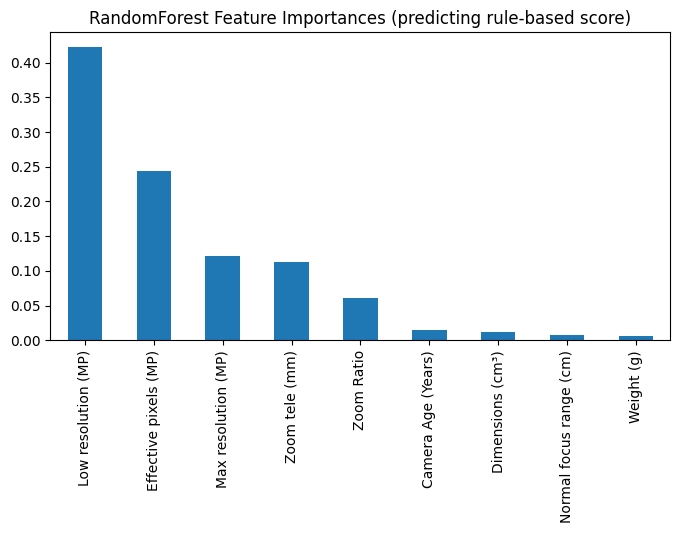

In [29]:
# Plot importances
importances = pd.Series(rf.feature_importances_, index=X_model.columns).sort_values(ascending=False)

plt.figure(figsize=(8,4))
importances.plot(kind='bar')
plt.title("RandomForest Feature Importances (predicting rule-based score)")
plt.show()

In [30]:
# Classification modeling

# Create labels
def score_to_label(s):
    if s >= 80: return "High"
    if s >= 60: return "Medium"
    return "Low"

cameras["Suitability_Label"] = cameras["Suitability Score (0-100)"].apply(score_to_label)

In [31]:
# Encode labels
label_map = {"Low":0, "Medium":1, "High":2}
y_cls = cameras["Suitability_Label"].map(label_map)

In [32]:
# Train a RandomForestClassifier
X_cls = X_model.fillna(X_model.median())
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train_c, y_train_c)
y_pred_c = clf.predict(X_test_c)

print(classification_report(y_test_c, y_pred_c, target_names=["Low","Medium","High"]))

              precision    recall  f1-score   support

         Low       0.99      0.99      0.99       167
      Medium       0.83      0.92      0.87        26
        High       1.00      0.62      0.77         8

    accuracy                           0.97       201
   macro avg       0.94      0.85      0.88       201
weighted avg       0.97      0.97      0.96       201



### ML Conclusions

After developing a rule-based suitability score for cameras, two supervised ML models were applied to **validate and quantify** the scoring logic.  
Both regression and classification techniques confirmed that the rule-based system aligns well with underlying data patterns.

---

#### 1. Regression Analysis

Two models were trained to predict the *Suitability Score (0–100)* using all numeric features:

| Model | RMSE | R² Score | Interpretation |
|--------|-------|-----------|----------------|
| **Linear Regression** | **0.90** | **0.9978** | Extremely high linear correlation between features and suitability score. |
| **Random Forest Regressor** | **2.64** | **0.9809** | Slightly lower precision, but captures non-linear feature effects effectively. |

**Key Insight:**  
The R² values above 0.98 for both models indicate that the rule-based score is **highly predictable and internally consistent**. Meaning our weighted design captures real feature relationships accurately.

---

#### 2. Feature Importance (from Random Forest)

The chart shows the most influential predictors in estimating the Suitability Score:

| Rank | Feature | Relative Importance | Meaning |
|------|----------|----------------------|----------|
| 1. | **Low Resolution (MP)** | 0.42 | Ensures clarity even under reduced image modes (e.g., night or motion capture). |
| 2. | **Effective Pixels (MP)** | 0.24 | Overall image sharpness and detail capture for license plates. |
| 3. | **Max Resolution (MP)** | 0.12 | High-res capability for evidence-quality footage. |
| 4. | **Zoom Tele (mm)** | 0.11 | Long-distance plate recognition. |
| 5. | **Zoom Ratio** | 0.06 | Flexibility for variable distances. |

Other physical parameters (weight, size) had minimal impact, supporting that **optical quality and resolution** dominate in determining camera suitability.

---

#### 3. Classification Results

To categorize cameras into *High*, *Medium*, and *Low* suitability groups, a **Random Forest Classifier** was trained on the same features.

| Metric | Low | Medium | High | Overall |
|---------|-----|---------|-------|----------|
| **Precision** | 0.99 | 0.83 | 1.00 | — |
| **Recall** | 0.99 | 0.92 | 0.62 | — |
| **F1-Score** | 0.99 | 0.87 | 0.77 | — |
| **Accuracy** | — | — | — | **0.97 (97%)** |

**Interpretation:**  
- The classifier performed **very well overall (97% accuracy)**.  
- Slight overlap between *Medium* and *High* classes is expected since their scores are numerically close.  
- This model demonstrates potential for **automatic categorization** of new camera models based on their specs.

---

### Final Conclusions

- Both **Regression (R² > 0.98)** and **Classification (97% accuracy)** validate the credibility of the rule-based approach.  
- **Low and Effective Resolution** are the most dominant features driving suitability for an E-Challan System.  
- The hybrid rule + ML method offers a **transparent, data-driven ranking system** that could guide camera procurement decisions.  
- This approach balances **technical rigor and interpretability**, ideal for early-stage deployment of AI-assisted urban infrastructure systems.

In [33]:
# Final Top-3 Recommendation
top3 = cameras.sort_values("Suitability Score (0-100)", ascending=False).head(3)

print("Top 3 Recommended Cameras for a Traffic E-Challan System:\n")

display(top3[[
    "Model", "Suitability Score (0-100)", "Effective pixels (MP)",
    "Zoom tele (mm)", "Zoom Ratio", "Weight (g)", "Price (USD)", "Camera Age (Years)"
]])

Top 3 Recommended Cameras for a Traffic E-Challan System:



,Model,Suitability Score (0-100),Effective pixels (MP),Zoom tele (mm),Zoom Ratio,Weight (g),Price (USD),Camera Age (Years)
666,Olympus SP-560 UZ,100.000000,8.0,486.0,18.0,365.0,449.0,18
708,Panasonic Lumix DMC-FZ18,99.480476,8.0,504.0,18.0,407.0,149.0,18
665,Olympus SP-550 UZ,97.086348,7.0,504.0,18.0,460.0,449.0,18
